<a href="https://colab.research.google.com/github/xehau/xehau_lessons/blob/master/linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Estimator で線形モデルを構築する

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/estimator/linear"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

## 概要

このエンドツーエンドのウォークスルーでは、`tf.estimator` API を使用してロジスティック回帰モデルをトレーニングします。このモデルはほかのより複雑なアルゴリズムの基準としてよく使用されます。


## セットアップ

In [ ]:
!pip install sklearn


In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

## Titanic データセットを読み込む

Titanic データセットを使用して、性別、年齢、船室クラスなどの特性に基づき、（やや悪趣味ではありますが）乗船者の生存を予測することを目標とします。

In [ ]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [ ]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## データを確認する

データセットには、次の特徴が含まれます。

In [ ]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


トレーニングセットと評価セットには、それぞれ 627 個と 264 個の例があります。

In [ ]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

乗船者の大半は 20 代から 30 代です。

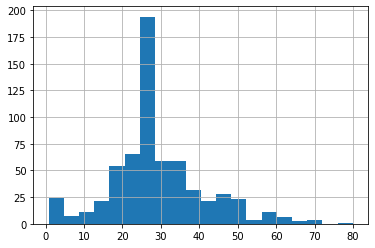

In [ ]:
dftrain.age.hist(bins=20)

男性の乗船者数は女性の乗船者数の約 2 倍です。

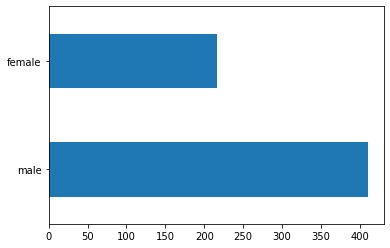

In [ ]:
dftrain.sex.value_counts().plot(kind='barh')

乗船者の大半は「3 等」の船室クラスを利用していました。

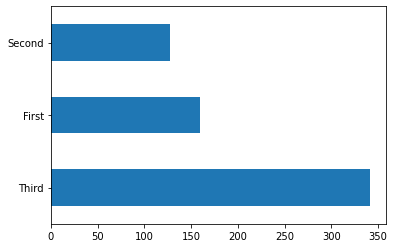

In [ ]:
dftrain['class'].value_counts().plot(kind='barh')

女性は男性よりも生存する確率がはるかに高く、これは明らかにモデルの予測特徴です。

Text(0.5, 0, '% survive')

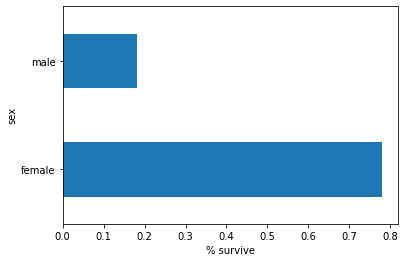

In [ ]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## モデルの特徴量エンジニアリング

Estimator は、モデルがどのように各行の入力特徴量を解釈すべきかを説明する[特徴量カラム](https://www.tensorflow.org/guide/feature_columns)というシステムを使用しています。Estimator は数値入力のベクトルを期待するのに対し、*特徴量カラム*はモデルがどのように各特徴量を変換すべきかが記述されています。

効率的なモデルを学習するには、適切な特徴カラムの選択と作成が鍵となります。特徴量カラムは、元の特徴量 `dict` の生の入力の 1 つ（*基本特徴量カラム*）または 1 つ以上の基本カラムに定義された変換を使って作成された新規カラム（*派生特徴量カラム*）のいずれかです。

線形 Estimator は、数値特徴とカテゴリ特徴の両方を利用します。特徴量カラムは TensorFlow Estimator と機能し、その目的はモデリングに使用される特徴量を定義することにあります。さらに、One-Hotエンコーディング、正規化、およびバケット化などのいくつかの特徴量エンジニアリング機能を提供します。

### 基本特徴量カラム

In [ ]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

`input_function` は、入力パイプラインをストリーミングの手法でフィードする `tf.data.Dataset` にデータを変換する方法を指定します。`tf.data.Dataset` は、dataframe や csv 形式ファイルなど、複数のソースを取ることができます。

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

次のようにデータセットを検査できます。

In [ ]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Third' b'First' b'Third' b'Third' b'Second' b'Second' b'Third' b'First'
 b'Third' b'Third']

A batch of Labels: [0 0 0 0 0 0 0 1 1 0]


また、`tf.keras.layers.DenseFeatures` レイヤーを使用して、特定の特徴量カラムの結果を検査することもできます。

In [ ]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[45.],
       [29.],
       [ 2.],
       [39.],
       [18.],
       [46.],
       [22.],
       [11.],
       [28.],
       [23.]], dtype=float32)

`DenseFeatures` は密なテンソルのみを受け入れ、それを最初にインジケータカラムに変換する必要のあるカテゴリカラムを検査します。

In [ ]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

すべての基本特徴量をモデルに追加したら、モデルをトレーニングすることにしましょう。モデルのトレーニングは、 `tf.estimator` API を使ってコマンド 1 つで行います。

In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.75, 'accuracy_baseline': 0.625, 'auc': 0.8317723, 'auc_precision_recall': 0.79436666, 'average_loss': 0.4790731, 'label/mean': 0.375, 'loss': 0.47184297, 'precision': 0.67368424, 'prediction/mean': 0.3684449, 'recall': 0.64646465, 'global_step': 200}


### 派生特徴量カラム

精度が 75% に達しました。それぞれの基本特徴量カラムを個別に使用しても、データを説明するには不足している場合があります。たとえば、性別とラベルの間の相関関係は、性別が変われば異なることがあります。そのため、`gender="Male"` と `gender="Female"` で単一モデルの重みのみを把握しただけでは、すべての年齢と性別の組み合わせをキャプチャすることはできません（`gender="Male"` と `age="30"` と `gender="Male"` と `age="40"` を区別するなど）。

さまざまな特徴量の組み合わせの間の違いを把握するには、*相互特徴量カラム*をモデルに追加できます（また、相互カラムの前に年齢カラムをバケット化できます）。

In [ ]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

組み合わせた特徴量をモデルに追加したら、モデルをもう一度トレーニングしましょう。

In [ ]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.75757575, 'accuracy_baseline': 0.625, 'auc': 0.8451791, 'auc_precision_recall': 0.7896944, 'average_loss': 0.47673723, 'label/mean': 0.375, 'loss': 0.46921062, 'precision': 0.65217394, 'prediction/mean': 0.42781442, 'recall': 0.75757575, 'global_step': 200}


これで、77.6% の精度に達しました。基本特徴量のみでトレーニングした場合よりわずかに改善されています。ほかの特徴量と変換を使用して、さらに改善されるか確認してみましょう！

このトレーニングモデルを使用して、評価セットからある乗船者に予測を立てることができます。TensorFlow モデルは、バッチ、コレクション、または例に対してまとめて予測を立てられるように最適化されています。以前は、`eval_input_fn` は評価セット全体を使って定義されていました。

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp33rxjs81/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


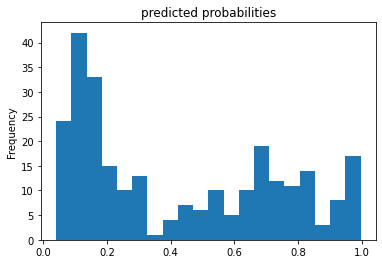

In [ ]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

最後に、結果の受信者操作特性（ROC）を見てみましょう。真陽性率と偽陽性率間のトレードオフに関し、より明確な予想を得ることができます。

(0.0, 1.05)

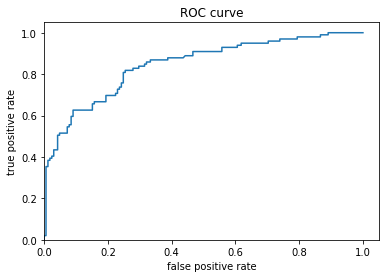

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)